Ομάδα

1.   Ιωάννα Βασιλικού 1115202100012
2.   Άγγελος Τσιτσόλη 1115202000200



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from matplotlib import colors
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import folium
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import re
from nltk import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Ερώτημα 1ο: Ανάλυση Δεδομένων (Data exploration)


In [34]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def remove_punctuation(input_string):
    # Make a translator object that will replace all punctuation with a space
    if isinstance(input_string, float):
        input_string = str(input_string)
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    # Use the translator object to remove punctuation from the input string
    no_punct = input_string.translate(translator)
    return no_punct

def remove_stopwords(input_string):
    if not isinstance(input_string, str):
        input_string = ' '.join(input_string)
    tokens = input_string.split()
    no_stop = [word for word in tokens if not word in stop_words]
    return ' '.join(no_stop)

def lemmatize_words(input_string):
    tokens = input_string.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

def text_cleaning(df):
    for col in ['description', 'amenities', 'name']:
        # convert column to string
        df[col] = df[col].astype(str)

        # replace "Wi-Fi" and "WI-FI" with "WIFI" and "WiFi"
        df[col] = df[col].apply(lambda x: str(x).replace("Wi-Fi", "WiFi").replace("WI-FI", "WIFI").replace("wi-fi", "wifi").replace("Wi-fi", "Wifi").replace("wi-Fi", "Wifi"))
         # remove <br />
        df[col] = df[col].str.replace('<br />', ' ')
        df[col] = df[col].str.replace('<br/>', ' ')
        df[col] = df[col].str.replace('< br />', ' ')
        df[col] = df[col].str.replace('< br/>', ' ')
        df[col] = df[col].str.replace('<b>', ' ')
        df[col] = df[col].str.replace('<b >', ' ')
        df[col] = df[col].str.replace('< b >', ' ')
        df[col] = df[col].str.replace('< b>', ' ')
        df[col] = df[col].str.replace('</b>', ' ')
        df[col] = df[col].str.replace('< /b>', ' ')
        df[col] = df[col].str.replace('</b >', ' ')
        df[col] = df[col].str.replace('< /b >', ' ')
        #remove punctuation
        df[col] = df[col].apply(remove_punctuation)
        #remove non ascii characters
        df[col] = df[col].apply(lambda x: x.encode("ascii", "ignore").decode())
        #tokenization
        df[col] = df[col].apply(lambda x: x.split())
        # #remove stopwords
        df[col] = df[col].apply(remove_stopwords)
        # #lemmatization
        df[col] = df[col].apply(lemmatize_words)

    # drop rows where any of the specified columns contain 'translation missing en hosting amenity 49' or 'translation missing en hosting amenity 50'
    df = df[~df.apply(lambda row: 'translation missing en hosting amenity 49' in ' '.join(row.values.astype(str)) or 'translation missing en hosting amenity 50'in ' '.join(row.values.astype(str)) or 'translation missing en hosting amenity 49 translation missing en hosting amenity 50' in ' '.join(row.values.astype(str)), axis=1)]

    # drop rows where 'description' column doesn't contain any letter
    df = df[df['amenities'].str.contains(r'[a-zA-Z]', na=False)]
    df = df[df['name'].str.contains(r'[a-zA-Z]', na=False)]


    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
def replace_nan_with_mean(df, column_name='review_scores_rating'):
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    mean_value = df[column_name].mean()
    mean_value = round(mean_value, 2)  # round to 2 decimal places
    df[column_name].replace(np.nan, mean_value, inplace=True)
    return df


def strip_everything(df):

    for col in df.columns:

        # replace $ symbol in price
        if col == 'price':
          df[col] = df[col].str.replace('$', '')

        # replace % symbol in hostr response rate
        if col == 'host_response_rate':
          df[col] = df[col].str.replace('%', '')

          # remove values outside of the range [1, 100]
          # Convert to numeric and replace non-numeric values with NaN
          df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')

          # Replace values outside the range [1, 100] with NaN
          df.loc[(df['host_response_rate'] > 100) | (df['host_response_rate'] < 1), 'host_response_rate'] = np.nan

          # Calculate the mean of the remaining values
          mean = df['host_response_rate'].mean()
          mean = round(mean, 2)  # round to 2 decimal places

          # Replace NaN values with the mean
          df['host_response_rate'].fillna(mean, inplace=True)
          # df[col] = df[col].astype(float).astype(pd.Int64Dtype())

        # make the longtitude a number without spaces
        if col in ['longtitude']:
          df[col] = df[col].str.replace(' ', '')

        # remove values outside the range [0, 20]
        if col in ['bedrooms', 'beds', 'bathrooms', 'accomodates']:
          df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric
          if col == 'bathrooms':
            room_to_bathrooms = {
                  'Entire home/apt': 3,
                  'Hotel room': 2,
                  'Private room': 1,
                  'Shared room': 1
            }
          df['bathrooms'] = df['room_type'].map(room_to_bathrooms)
          if col != 'bathrooms':
              mean = df[col].mean()
              mean = round(mean, 2)  # round to 2 decimal places
              df[col].fillna(mean, inplace=True)
              df.loc[(df[col] > 20) | (df[col] < 0), col] = np.nan

        # check the values to be "t" or "f"
        if col in ['host_has_profile_pick', 'host_identity_verified', 'instant_bookable']:
          df.loc[~df[col].isin(['t', 'f']), col] = np.nan

        # delete the rows without availability
        if col == 'availability_365':
          mean = df[col].mean()
          mean = round(mean, 2)  # round to 2 decimal places
          df[col].fillna(mean, inplace=True)

        # keep only the integer from the number
        if col in ['host_response_rate', 'bedrooms', 'beds', 'review_scores_rating', 'price', 'review_scores_rating']:
            df[col] = df[col].astype(str).str.split('.').str[0]

    #first_review
    df['first_review'] = df['first_review'].replace('""', pd.NA, regex=False)
    df = df.dropna(subset=['first_review'])

    #amenities
    df = df[df['amenities'] != '{}']

    #minimum_nights
    #Keep rows where 'minimum_nights' is less than or equal to 30 and greater than 0
    df = df.loc[(df['minimum_nights'] <= 30) & (df['minimum_nights'] > 0)]

    #review_scores_rating
    df['review_scores_rating'] = df['review_scores_rating'].replace('""', pd.NA, regex=False)

    #neighbourhood
    df['neighbourhood'] = df['neighbourhood'].replace('""', pd.NA, regex=False)

    #price
    # Convert 'price' column to numeric, non-numeric values are converted to NaN
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

    #last_review
    df['last_review'] = df['last_review'].replace('""', pd.NA, regex=False)


    return df

In [36]:
# give the file paths
listings_path_june = '/content/drive/MyDrive/ΤΕΔΕ/2023/june/listings.csv'
listings_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2023/march/listings.csv'
listings_path_september = '/content/drive/MyDrive/ΤΕΔΕ/2023/september/listings.csv'

listings0_path_june = '/content/drive/MyDrive/ΤΕΔΕ/2023/june/listings0.csv'
listings0_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2023/march/listings0.csv'
listings0_path_september = '/content/drive/MyDrive/ΤΕΔΕ/2023/september/listings0.csv'

# select the columns that we want to use for the results
columns_to_select = ['id', 'bedrooms', 'beds', 'review_scores_rating',
                     'number_of_reviews', 'neighbourhood', 'neighbourhood_cleansed', 'name', 'latitude',
                     'longitude', 'last_review', 'instant_bookable', 'host_since',
                     'host_response_rate', 'host_identity_verified', 'host_has_profile_pic',
                     'first_review', 'description', 'bathrooms',
                     'accommodates', 'amenities', 'room_type',
                     'property_type', 'price', 'availability_365', 'minimum_nights']

# read a data frame from every file
listings_df_june = pd.read_csv(listings_path_june, usecols=columns_to_select, nrows=6000)
listings_df_march = pd.read_csv(listings_path_march, usecols=columns_to_select, nrows=6000)
listings_df_september = pd.read_csv(listings_path_september, usecols=columns_to_select, nrows=6000)

listings0_df_june = pd.read_csv(listings0_path_june)
listings0_df_march = pd.read_csv(listings0_path_march)
listings0_df_september = pd.read_csv(listings0_path_september)

# create a new column 'month' with the corresponding month name for each DataFrame
listings_df_june['month'] = 'june'
listings_df_march['month'] = 'march'
listings_df_september['month'] = 'september'

# merge the data from the three months
listings_df = pd.concat( [listings_df_june, listings_df_march, listings_df_september] , ignore_index=True )
listings0_df = pd.concat( [listings0_df_june, listings0_df_march, listings0_df_september] , ignore_index=True )

df = listings_df

# call the function
df = strip_everything(df)

#replace nan from reviews score with the mean
df = replace_nan_with_mean(df)

# text cleaning
df = text_cleaning(df)

# clean 'amenities' column
# List of words to replace and their replacements
words_to_replace = [
    (["Internet", "Wifi", "Heating", "Ethernet connection","Jbl portable Bluetooth sound system" ,"Pocket wifi", "EV charger", "Netflix", "HBO GO", "Cable", "Central heating","Fast wifi", "AC split type ductless system", "split type ductless system",
      "Pioneer sound system aux","Chromecast","standard cable","Bosh","Izola","Korres","HITACHI","Bluetooth","sound system","sound system Bluetooth ","Robin","PHILIPS","Siemens","LG","Candy","Zanussi","Morris","Window AC unit","PITSOS",
      "Portable air conditioning","Pitsos","HITACHI sound system","sound system aux","JBL Bluetooth sound system","Toshiba conditioner","Darel conditioner",
      "Mitsubishi conditioner","Disney","Apple","Panasonic SA PMX","Moris retro","Bluetooth sound system","Sonos wifi","HBO Max Hulu","Sony","Huaw sound system","Radiant heating","Davoline",
      "HBO Max Fire","Hulu","Pioneer sound system","SONY sound system","Sonos sound system","Logitec sound system aux","AEG","electric","Denon sound system"], 'Electricity_Technology'),
    (["Hangers", "Bed linen", "Extra pillow blanket", "Indoor fireplace wood burning","Room darkening shade",
      "Indoor fireplace", "Private living room", "Fire pit", "Bedroom comfort",
      "Firm mattress", "Memory foam mattress", "Murphy bed", "Pillow top mattress",
      "Mudroom", "Day bed", "Standing valet","dresser",
      "Ironing Board","Drying rack clothing","Clothing storage closet dresser",
      "Clothing storage closet","Clothing storage","walk closet",
      "closet dresser","Artisti Italiani","wardrobe dresser",
      "wardrobe","CAJOLINE conditioner","Lenor conditioner","Cajolin conditioner","Soupline conditioner",
      "Zealots Nature Coco mat conditioner","Ariel conditioner","Cajoline conditioner","closet"], 'Indoor'),
    (["HDTV","Cable TV", "Smart TV", "TV", "Air conditioning", "aux","Elevator",
      "Buzzer wireless intercom", "Washer Dryer", "Hair dryer", "Iron",
      "Washer", "Dryer", "Game console", "DVD player", "Keypad",
      "Sound system", "High resolution computer monitor", "Printer",
      "Fax machine", "Central air conditioning", "Ceiling fan",
      "Projector screen", "Amazon Echo", "Warming drawer",
      "Heat lamp","Portable fan","Amazon Prime Video","Record player","premium cable","Xbox"], 'Electronic_Devices'),
    (["Safety card", "Self check", "Fire extinguisher", "24 hour check", "Smoke detector", "Carbon monoxide detector",
      "Lock bedroom door", "Self check Lockbox", "Private entrance", "Window guard", "Doorman",
      "Fireplace guard", "Smart lock", "Not fully fenced","Lockbox", "Security camera property", "Smoke alarm", "Carbon monoxide alarm","Safe"], 'Security'),
    (["Portable heater","Luggage dropoff allowed", "Cleaning checkout", "Smoking allowed", "Building staff",
      "Suitable event", "Well lit path entrance", "Exercise equipment free weight","Formal dining area", "Exercise equipment",
      "Heated floor", "Free resort access","available year open  hour ","Laptop friendly workspace", "Dedicated workspace","Books reading material","Cleaning product","Dining","Crib available upon request","Paid parking garage premise",
      "Free dryer","aid resort access","free weight yoga mat","Piano","Free parking garage premise","Paid dryer",
      "Paid washer u In building","available upon request",
      "french press","always listing","Cleaning available stay","Paid washer","Resort access"], 'Services'),
    (["Stand alone steam shower", "Le Petit Marseillais conditioner","Le Petit Marseillais shampoo","Karavaki body soap","Bidet", "Heated towel rack","Organic body soap","En suite bathroom", "Soaking tub",
      "Roll shower", "Toilet paper", "Toilet", "Rain shower", "Bathroom essential", "Bathtub", "Walk shower", "Body soap",
      "Bath towel", "Hot water", "First aid kit", "Shampoo", "Essentials",
      "Touchless faucet", "Shower gel", "Laundromat nearby", "Free washer",
      "Conditioner","Lux body soap","body soap","Apivita Organic","Korres shampoo",
      "Organic conditioner","Organic shampoo","Various shampoo"
      ,"VARIOUS shampoo","VARIOUS conditioner","Karavak","Papoutsanis",
      "Professional shampoo conditioner","Fair Trade conditioner","Aqua Senses shampoo","Amalfi honey shampoo","Zealots conditioner",
      "Head soulders conditioner","Sette shampoo","Satinique conditioner","Olivia Papoutsanis conditioner","Olivia Papoutsanis shampoo",
      "Palette GLISS conditioner","GLISS shampoo","Korres conditioner","Pantene conditioner","Pantene shampoo",
      "Pantene Dove Johnson","KORRES conditioner","OLIVE ERA conditioner","SYOSS conditioner","Apivita conditioner",
      "Open Cosmetics conditioner","Apivita natural beauty product shampoo",
      "Papoutsanis conditioner",
      "Papoutsanis shampoo","Jo Malone conditioner","Olive tree conditioner","TOILETRIES ERGONFOODS conditioner",
      "Zealots nature Coco mat conditioner","Elemis conditioner",
      "Any Brand conditioner","Elvive L Oreal conditioner",
      "Sea Sky conditioner",
      "Sea Sky shampoo","Fair trade conditioner"
      ,"LOREAL conditioner","Different brand conditioner","Unbranded conditioner",
      "HEAD AND SHOULDERS conditioner","Dust Cream conditioner",
      "Apivita natural beauty product conditioner",
      "Supline conditioner","SOUPLINE conditioner","Comfort conditioner",
      "Hair cream conditioner","Private Label conditioner",
      "Private brand conditioner","Elvive conditioner",
      "Private label conditioner","Johnson Baby     conditioner","Johnson Baby     shampoo",
      "Wela conditioner","SYOSS shampoo","CIEN shampoo","Body Gel shampoo",
      "Apivita shampoo","TOILETRIES ERGONFOODS shampoo",
      "Private Label shampoo","Zealots Nature Coco mat shampoo",
      "Zealots nature Coco mat shampoo",
      "Aqua sens shampoo","Aqua shampoo","Dove","NV Cosmetics","Aqua Senses",
      "Open Cosmetics shampoo","Physis shampoo","APIVITA shampoo","Papourtsanis",
      "Olive oil green soap","Dimitra Goula skincare","Zealers shampoo","it Marseillais conditioner","it Marseillais",
      "WASH AND GO shampoo","ORZENE shampoo","Dafnis shampoo","Pandrosia Natural   shampoo","Jo Malone shampoo","Elvive L Oreal shampoo","My root conditioner","Open Cosmetics",
      "Generic shampoo","Syoss shampoo","ADULT BABY SHAMPOOS shampoo","Pandrosia Natural Shower Gel",
      "Private label shampoo","Zealots shampoo","Marseillais shampoo","Private brand shampoo","Palmolive shampoo","Folding convertible high chair",
      "Shower Gel per person per stay body lotion conditioner","Old Spice Shower Gel"], 'Bathroom'),
    (["Family kid friendly", "Patio balcony", "Host greets", "Long term stay allowed", "Childrens book toy",
      "un play Travel crib","Crib","Pack n Play travel crib", "Childrens dinnerware", "Changing table", "Outlet cover",
      "Baby bath", "Babysitter recommendation", "Baby monitor", "Table corner guard", "High chair",
      "Stair gate", "Dog", "Cat", "Pets live property", "Pets allowed", "Pet", "pet", "Pack","Children us book toy",
      "Board game", "Children us dinnerware","Paid booster seat high chair",
      "Bikes","Baby safety gate","age   year old   year old","age   year old",
      "year old","Mosquito net", "Paid crib","Booster seat high chair",
      "Standalone high chair"], 'Family'),
    (["Electric profiling bed", "Ground floor access", "Disabled parking spot",
      "Fixed grab bar", "Wide clearance shower toilet", "Wide clearance shower", "Accessible height toilet",
      "Wide clearance toilet", "Fixed grab bar shower", "Wide entryway",
      "Wheelchair accessible", "Flat path front door", "Wide hallway clearance", "Accessible height bed",
      "Handheld shower head", "Wide doorway", "Step free access", "Wide clearance bed", "Single level home", "Shower chair", "Bath chair", "bath chair", "shower", "toilet"], 'Accessibility'),
    (["Electric refrigerator","Electrolux gas stove","BBQ grill charcoal wood burning","Whirlpool induction stove","Whirlpool electric stove","Whirlpool stainless steel electric stove","Whirlpool oven","Whirlpool refrigerator","Private BBQ grill wood burning","Robin stainless steel electric stove","charcoal gas","wood burning stove","Miele stainless steel electric stove","Miele stove","Miele electric stove","Miele double oven","MIELE refrigerator","Miele oven"
      "Miele stainless steel oven","Miele induction stove","Electric stove top hob stove","Stainless steel gas stove","Microwave", "Pitsos stainless steel",
      "Coffee maker","Refrigerator","Dishwasher","Oven","Stove","Kitchen","Full kitchen","Convection oven",
      "Kettle", "kettle", "Mini fridge","Espresso machine","Double oven","Wine cooler","Steam oven","Gas oven",
      "Freezer","kitchen","double oven","Kitchenette","Electrolux Electric stove","Electrolux stainless steel","Dishes silverware","Cooking basic","Breakfast","BBQ grill",
      "Table", "table", "Electric stove","electric stove", "Baking sheet","Wine glass","Coffee","Toaster","Siemens gas stove","Blender","espresso machine",
      "drip coffee maker","Teka stainless steel gas stove","gas","Bosch refrigerator","Barbecue utensil","Stainless steel","oven",
      "stainless steel","Rice maker","Gas stove","Nespresso pour coffee",
      "pour coffee","Induction stove","induction stove","Nespresso","gas stove",
      "Teka","I refrigerator","Keurig coffee machine","Pitsos refrigerator","BOSS refrigerator","refrigerator AEG",
      "Medium sized standing fridge refrigerator","Miele refrigerator",
      "Siemens stove","Pitsos gas stove","Miele","SIEMENS refrigerator","LG refrigerator","stove","MORRIS refrigerator","Zanussi refrigerator","Mini Cooker","BOSCH refrigerator",
      "AEG refrigerator","Whirlpool","Samsung refrigerator","WHIRLPOOL stove"
      ,"BOSH refrigerator","Morris refrigerator","Bosch gas stove","Trash compactor","Beach access","Indesit refrigerator","Bread maker","Green olive oil","La Germania gas stove","SAMSUNG refrigerator"
      ,"SIEMENS stove","Inventor refrigerator","refrigerator"],'Kitchen'),
    (["Lake access", "Hammock", "Private pool", "Sauna", "Alfresco bathtub","Fire",
      "Shared gym", "Sun lounger", "Jetted tub", "Beach view", "Private hot tub",
      "Beachfront", "Waterfront", "Outdoor parking", "Pool", "Ski", "Mountain view",
      "Terrace", "Gym", "Free carport premise","Private gym","Balcony", "Outdoor seating", "Terrace Balcony", "Hot tub",
      "Beach essential", "Free parking premise", "Free street parking", "Paid parking premise",
      "Garden backyard","Private patio balcony", "Outdoor furniture","City skyline view","Shared backyard","Fully fenced", "Courtyard view","Garden view","Park view","Private backyard","Outdoor dining area",
      "Ocean view","Backyard","Sea view","Outdoor","Marina view ","Private outdoor pool","Ping pong","Private sauna","treadmill","Paid parking lot premise",
      "Shared patio balcony","Shared hot tub","Resort view","cover rooftop","heated pool","Valley view","yoga mat","Lidl","Desert view","Private gym nearby","Vineyard view","Private outdoor kitchen","Public shared beach access","Shared outdoor pool rooftop",
      "Paid street parking premise","Private indoor pool available year heated","Private outdoor","Shared pool","Kayak",
      "Free residential garage premise","stationary bike","Shared outdoor pool available seasonally","Bay view","Golf course view","Harbor view","available year open specific hour","Private gym building",
      "Free driveway parking premise"], 'Outdoor'),
    (["translation missing en hosting amenity 50", "translation missing en hosting amenity 49"], 'Error'),
    (["Other","nearby","Mbps","Various","single","u In unit",
      "u  space","u uaIn unit","u ubb ubb ubf","u In building","Private Label","HUMAN","Single","United","Coffee maker", "Hot water", "Bed linen", "Ethernet connection", "Various", "High chair", "Pack n play", "Travel crib", "Hangers", "Central heating", "Extra pillow blanket", "Self check", "Private patio balcony", "Refrigerator", "Essentials", "Wifi", "Cooking basic", "Oven", "Shower gel", "Free street parking", "Single level home", "Smart lock", "Shampoo", "43 HDTV", "Dishes silverware", "Hair dryer", "Laundromat nearby", "Free washer In unit", "Iron",
      "AC split type ductless system", "Kitchen", "Microwave", "Electric stove",], '')
]

# delete the numbers from the amenities column
df['amenities'] = df['amenities'].str.replace('\d+', '', regex=True)

# Replace the words in the 'amenities' column
for words, replacement in words_to_replace:
    for word in words:
        df['amenities'] = df['amenities'].str.replace(word, replacement, regex=False)

# create the output file
df.to_csv('output.csv', index=False)

In [ ]:
#Combining and cleaning the reviews file for question 1.10

reviews_path_june = '/content/drive/MyDrive/ΤΕΔΕ/2023/june/reviews.csv'
reviews_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2023/march/reviews.csv'
reviews_path_september = '/content/drive/MyDrive/ΤΕΔΕ/2023/september/reviews.csv'

# select the columns that we want to use for the results
columns_to_select = ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments' ]

# Read the CSV files into dataframes
df_reviews_june = pd.read_csv(reviews_path_june, usecols=columns_to_select)
df_reviews_march = pd.read_csv(reviews_path_march, usecols=columns_to_select)
df_reviews_september = pd.read_csv(reviews_path_september, usecols=columns_to_select)

# Merge the data from the three months
df_reviews = pd.concat([df_reviews_march, df_reviews_june, df_reviews_september], ignore_index=True)

# Convert all values in 'comments' column to string
df_reviews['comments'] = df_reviews['comments'].astype(str)

df_reviews['comments'] = df_reviews['comments'].replace(r'[^\w\s,]', ' ', regex=True)
#remove punctuation
df_reviews['comments'] = df_reviews['comments'].apply(remove_punctuation)
# Convert all values in 'comments' column to string and remove non-ASCII characters
df_reviews['comments'] = df_reviews['comments'].astype(str).apply(lambda x: x.encode("ascii", "ignore").decode())
#tokenization
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: x.split())
#remove stopwords
df_reviews['comments'] = df_reviews['comments'].apply(remove_stopwords)
#lemmatization
df_reviews['comments'] = df_reviews['comments'].apply(lemmatize_words)

#drop non words
df_reviews = df_reviews[df_reviews['comments'].str.contains(r'[a-zA-Z]', na=False)]

# Drop rows where 'listing_id' column doesn't contain a number made from the digits 1-9
df_reviews = df_reviews[df_reviews['listing_id'].astype(str).str.contains(r'^[1-9]+$', na=False)]


# Drop rows where 'comments' column is empty or contains only whitespace
df_reviews = df_reviews[df_reviews['comments'].str.strip().astype(bool)]

# create the output file
df_reviews.to_csv('reviews_output.csv', index=False)

Ερώτημα 1.1

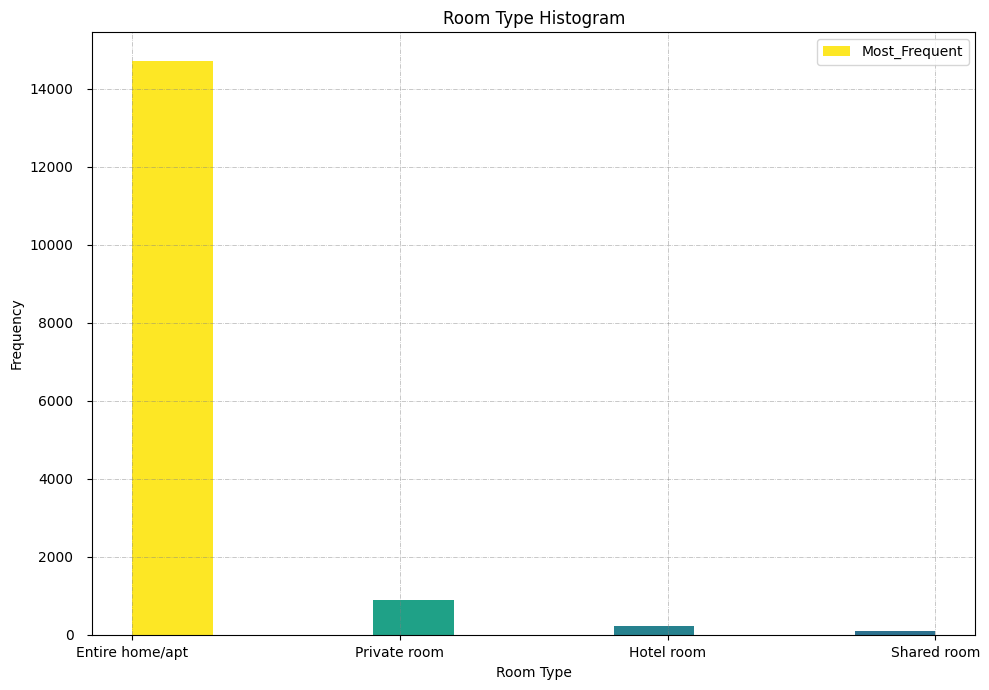

In [ ]:
# ####################################################################### #
# Question 1.1

# load the data from the CSV file
df = pd.read_csv('output.csv')

# use the data frpm the 'room_types' column
x = df['room_type']

legend = ['Most_Frequent']

# create histogram
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)

# αdd padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)

# add x and y gridlines
axs.grid(True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)

# create histogram
N, bins, patches = axs.hist(x, bins = 10)

# set colors
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# format the plot
plt.xlabel("Room Type")
plt.ylabel("Frequency")
plt.legend(legend)
plt.title('Room Type Histogram')

# save the plot to a file
plt.savefig('question_1_1.png')

# ####################################################################### #

Ερώτημα 1.2

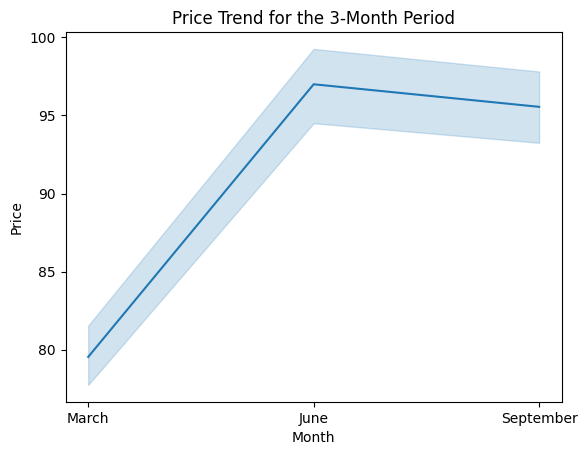

In [ ]:
# ####################################################################### #
# Question 1.2

df_j = listings_df_june
df_s = listings_df_september
df_m = listings_df_march

# drop the duplicate rows
df_j = df_j.drop_duplicates()
df_s = df_s.drop_duplicates()
df_m = df_m.drop_duplicates()

# call the function
df_j = strip_everything(df_j)
df_s = strip_everything(df_s)
df_m = strip_everything(df_m)


# Calculate the mean
mean_price_j = df_j['price'].mean()
mean_price_s = df_s['price'].mean()
mean_price_m = df_m['price'].mean()


june_price = df_j['price']
september_price = df_s['price']
march_price = df_m['price']

plt.figure()
# Create a new DataFrame with the price data for each month
df_months = pd.DataFrame({
    'March': march_price,
    'June': june_price,
    'September': september_price
})

# Melt the DataFrame to a long format which is suitable for seaborn
df_months = df_months.melt(var_name='Month', value_name='Price')

# Use seaborn's lineplot function to create the graph
sns.lineplot(data=df_months, x='Month', y='Price')

# Set the labels and title for the graph
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price Trend for the 3-Month Period')

# Save the plot to a file
plt.savefig('question_1_2.png')

# ####################################################################### #

Ερώτημα 1.3

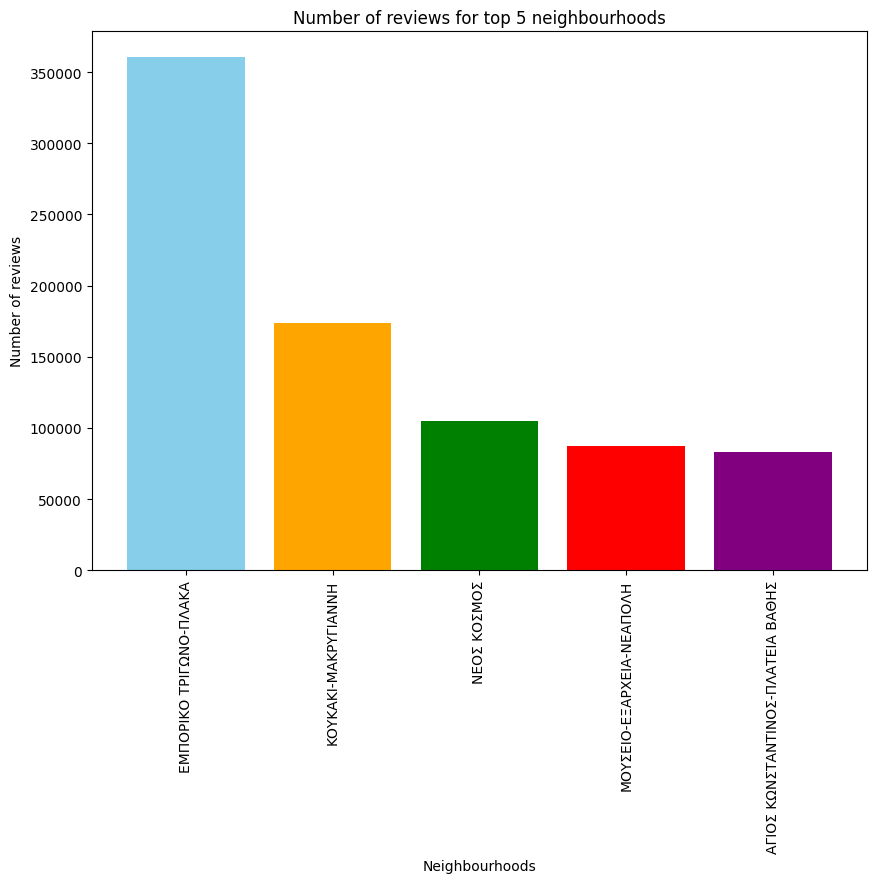

In [ ]:
# ####################################################################### #
# Question 1.3

# Load the data from the CSV file
df = pd.read_csv('output.csv')

# Get the top five neighbourhoods with the most reviews
top_five_neighbourhoods = df.groupby('neighbourhood_cleansed')['number_of_reviews'].sum().nlargest(5)

# Create a list of colors
colors = ['skyblue', 'orange', 'green', 'red', 'purple']

# Create bar plot with colors
plt.figure(figsize=(10, 7))
plt.bar(top_five_neighbourhoods.index, top_five_neighbourhoods.values, color=colors)

# Format the plot
plt.xlabel("Neighbourhoods")
plt.ylabel("Number of reviews")
plt.title('Number of reviews for top 5 neighbourhoods')
plt.xticks(rotation=90)

# Adjust y-axis to show numbers per 5000
max_y = top_five_neighbourhoods.max()
plt.yticks(np.arange(0, max_y+1, 50000))

# Save the plot to a file
plt.savefig('question_1_3.png')

# ####################################################################### #

Ερώτημα 1.4

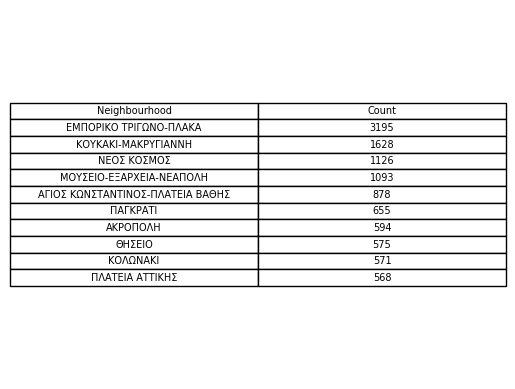

In [ ]:
# ####################################################################### #
# Question 1.4

# Read the csv file
df_unique = pd.read_csv('output.csv')

# Count the occurrences of each neighbourhood
neighbourhood_counts = df_unique['neighbourhood_cleansed'].value_counts()

# Create a DataFrame from the neighbourhood_counts Series
df_table = pd.DataFrame({'neighbourhood_cleansed': neighbourhood_counts.index, 'Count': neighbourhood_counts.values})

# Sort the counts in descending order
sorted_neighbourhoods = df_table.sort_values(by='Count', ascending=False)

# Select the first 10 neighbourhoods
top_neighbourhoods = sorted_neighbourhoods.head(10)

# Get data
neighbourhoods = top_neighbourhoods['neighbourhood_cleansed'].tolist()
counts = top_neighbourhoods['Count'].tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(neighbourhoods, counts))
ax.table(cellText=table_data, colLabels=['Neighbourhood', 'Count'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_4.png')

# ####################################################################### #

Ερώτημα 1.5

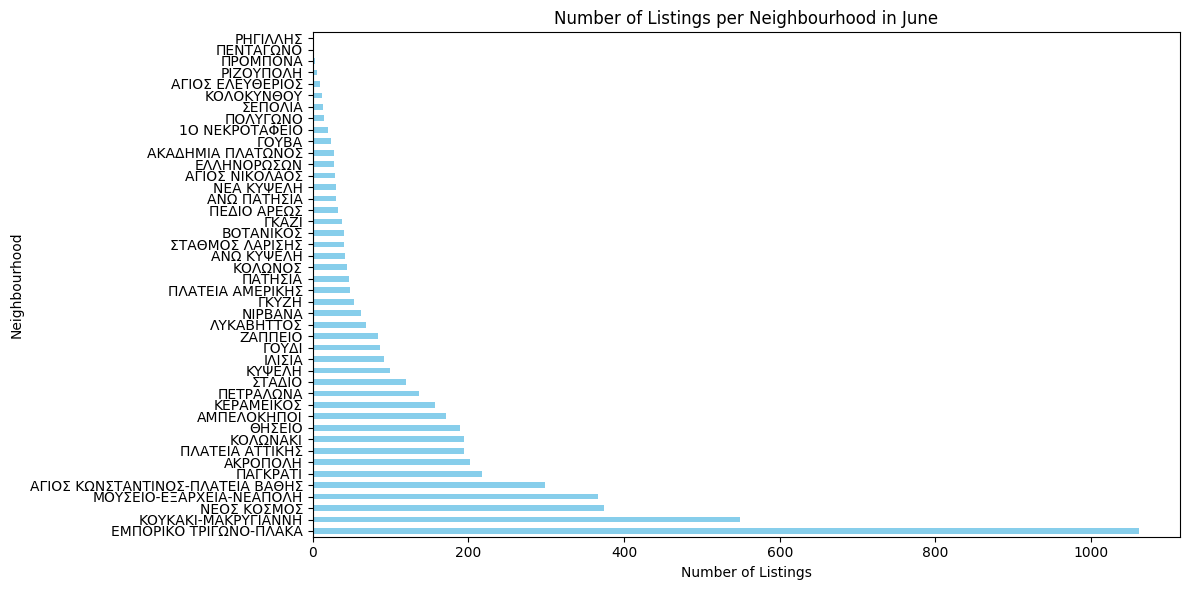

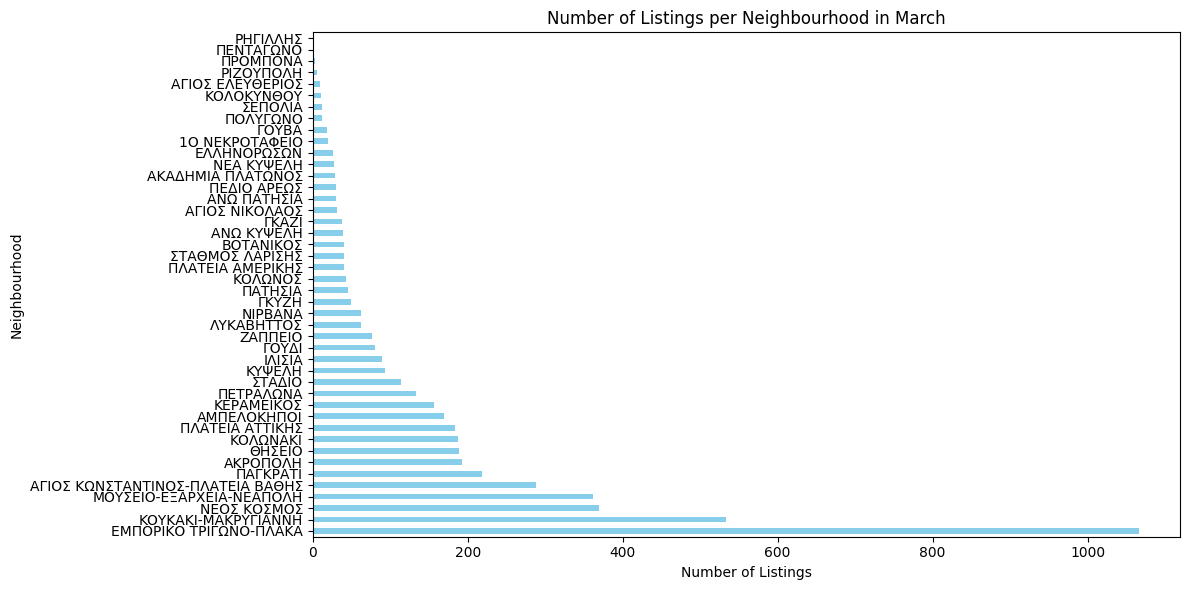

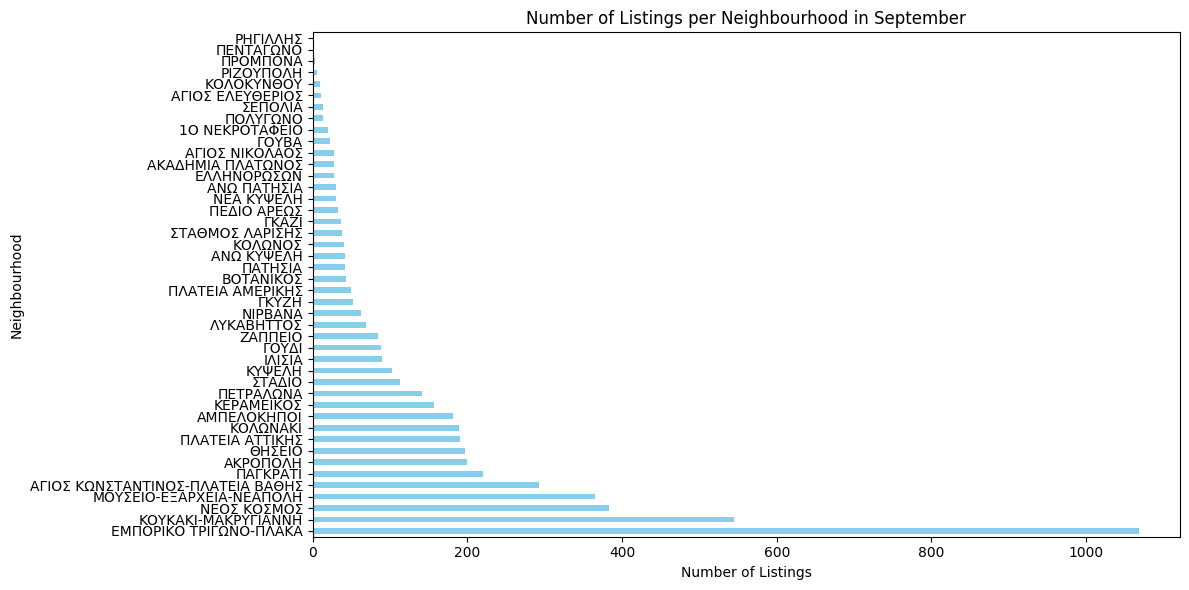

In [ ]:
# ####################################################################### #
# Question 1.5

# Load the data from the CSV file
df = pd.read_csv('output.csv')

# Drop duplicate rows based on the 'id' column
df_unique = df.drop_duplicates(subset='id')

# Group by 'month' and 'neighbourhood' and count occurrences
neighbourhood_counts = df.groupby(['month', 'neighbourhood_cleansed']).size().unstack(fill_value=0)

# Plot histograms for each month
months = ['june', 'march', 'september']

for month in months:
    plt.figure(figsize=(12, 6))

    # Sort neighbourhoods by count in descending order
    sorted_neighbourhoods = neighbourhood_counts.loc[month].sort_values(ascending=False)

    # Plot histogram
    sorted_neighbourhoods.plot(kind='barh', color='skyblue')  # 'barh' for horizontal bars

    # Add title and labels
    plt.title(f'Number of Listings per Neighbourhood in {month.capitalize()}')
    plt.xlabel('Number of Listings')
    plt.ylabel('Neighbourhood')

    plt.tight_layout()

    # Save the plot to a file
    plt.savefig('question_1_5.png')

# ####################################################################### #

Ερώτημα 1.6

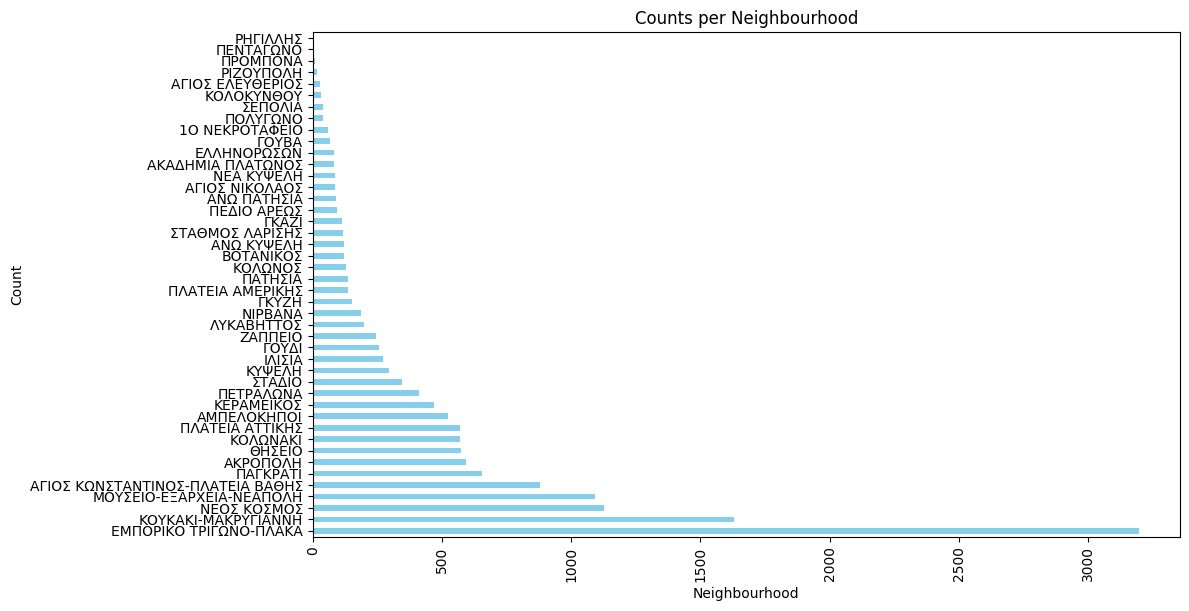

In [42]:
# ####################################################################### #
# Question 1.6

# Drop duplicate rows based on the 'id' column
df_unique = pd.read_csv('output.csv')

# Count the occurrences of each neighbourhood
neighbourhood_counts = df_unique['neighbourhood_cleansed'].value_counts()

plt.figure(figsize=(12, 6))

# Sort neighbourhoods by count in descending order
sorted_neighbourhoods = neighbourhood_counts.sort_values(ascending=False)

# Plot histogram
sorted_neighbourhoods.plot(kind='barh', color='skyblue')  # 'barh' for horizontal bars

# Add title and labels
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.title('Counts per Neighbourhood')

plt.tight_layout()

# Rotate x-axis labels for better visibility if they are long
plt.xticks(rotation=90)

# Save the plot to a file
plt.savefig('question_1_6.png')

# ####################################################################### #

Ερώτημα 1.7

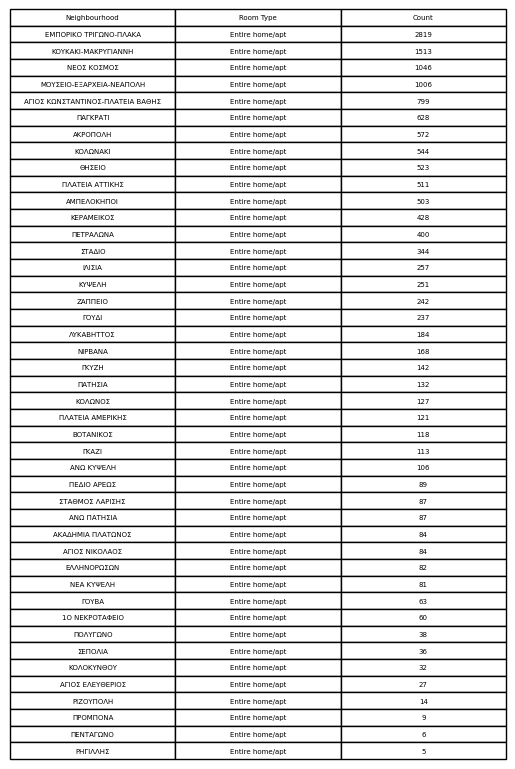

In [ ]:
# ####################################################################### #
# Question 1.7

# Load the data from the CSV file
df = pd.read_csv('output.csv')

# Group by 'neighbourhood' and 'room_type' and count occurrences
neighbourhood_room_type_counts = df.groupby(['neighbourhood_cleansed', 'room_type']).size().reset_index(name='count')

# Find the most frequent room_type for each neighbourhood
idx = neighbourhood_room_type_counts.groupby(['neighbourhood_cleansed'])['count'].transform(max) == neighbourhood_room_type_counts['count']
most_frequent_room_types = neighbourhood_room_type_counts[idx].set_index('neighbourhood_cleansed')

# Sort by count in descending order
most_frequent_room_types = most_frequent_room_types.sort_values('count', ascending=False)

# Get data
neighbourhoods = most_frequent_room_types.index.tolist()
room_types = most_frequent_room_types['room_type'].tolist()
counts = most_frequent_room_types['count'].tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(neighbourhoods, room_types, counts))
ax.table(cellText=table_data, colLabels=['Neighbourhood', 'Room Type', 'Count'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_7.png')

# ####################################################################### #

Ερώτημα 1.8

<ipython-input-17-ff98c99d5248>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_type_df['price'] = pd.to_numeric(room_type_df['price'], errors='coerce')


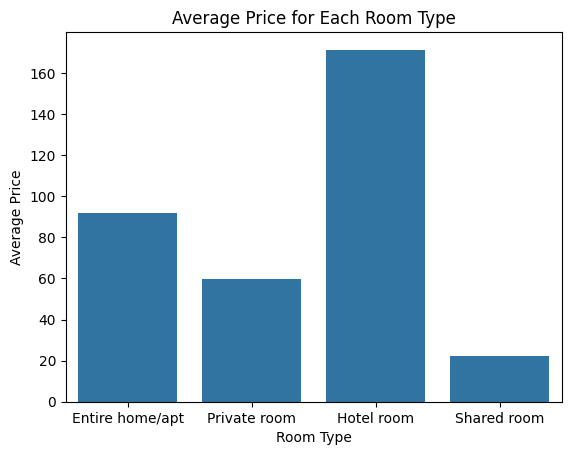

In [ ]:
# ####################################################################### #
# Question 1.8

# Find all unique room types
room_types = df['room_type'].unique()

# Initialize an empty dictionary to store the average price for each room type
avg_prices = {}

# Loop over the unique room types
for room_type in room_types:
    # Filter the DataFrame to only include rows with the current room type
    room_type_df = df[df['room_type'] == room_type]

    room_type_df['price'] = pd.to_numeric(room_type_df['price'], errors='coerce')

    # Calculate the average price for the current room type and store it in the dictionary
    avg_prices[room_type] = room_type_df['price'].mean()

# Convert the dictionary to a DataFrame
avg_prices_df = pd.DataFrame(list(avg_prices.items()), columns=['Room Type', 'Average Price'])

# Use seaborn's barplot function to create the histogram
sns.barplot(data=avg_prices_df, x='Room Type', y='Average Price')

# Set the labels and title for the graph
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.title('Average Price for Each Room Type')

# Save the plot to a file
plt.savefig('question_1_8.png')

# ####################################################################### #

Ερώτημα 1.9

In [ ]:
# ####################################################################### #
# Question 1.9

# Load the data
df1 = pd.read_csv('output.csv')

# Filter rows where 'month' is 'march'
df = df1[df1['month'] == 'march'].head(5000)

# Create a new map centered around the average latitude and longitude values
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=13)

# Add a marker for each property
for idx, row in df.iterrows():
    # Create a popup with the desired information
    popup_text = f"Room Type: {row['room_type']}"
    popup = folium.Popup(popup_text, max_width=300)

    # Create and add the marker to the map
    marker = folium.Marker(location=[row['latitude'], row['longitude']], popup=popup)
    marker.add_to(m)

# Save the map
m.save('question_1_9.html')

# ####################################################################### #

Ερώτημα 1.10

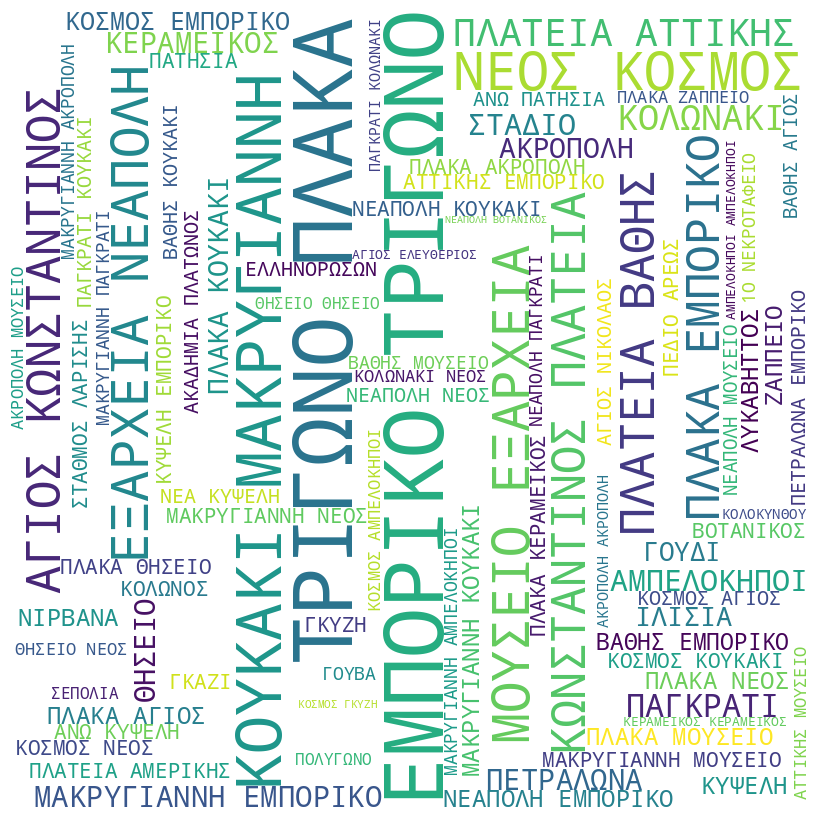

<Figure size 640x480 with 0 Axes>

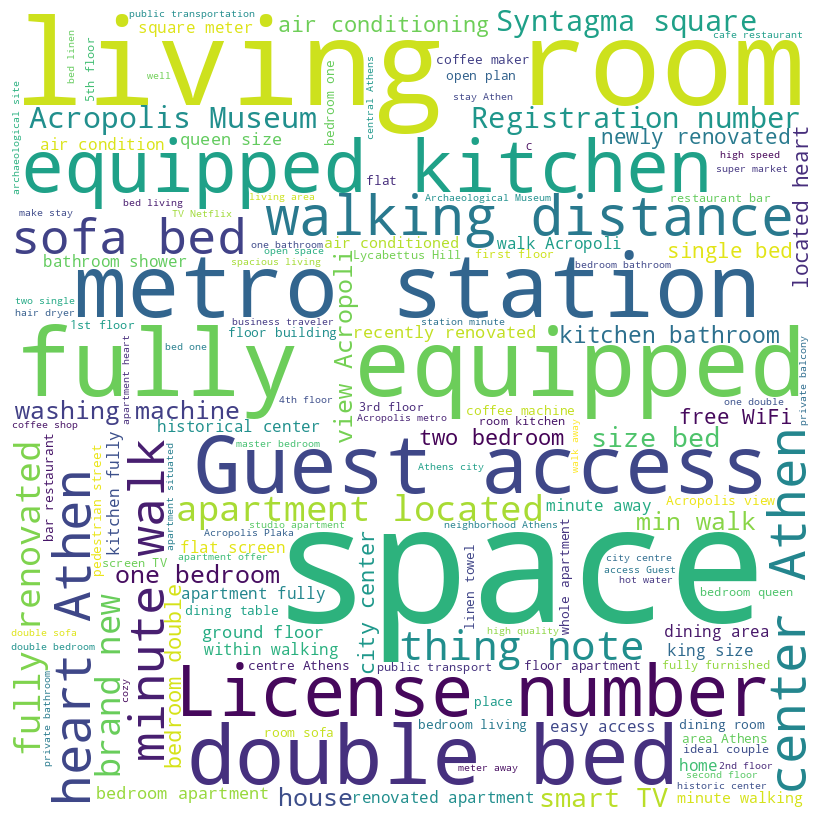

<Figure size 640x480 with 0 Axes>

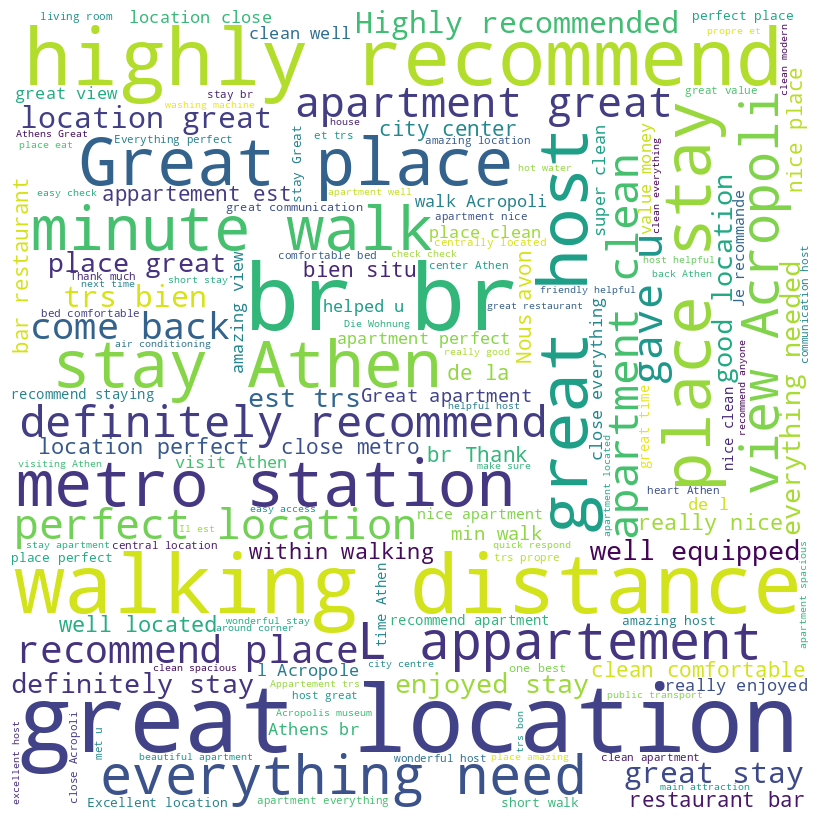

In [22]:
# ####################################################################### #
# Question 1.10

# Read the CSV file
df = pd.read_csv('output.csv')

# Convert the 'neighbourhood' column to a single string
text = ' '.join(df['neighbourhood_cleansed'])

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10a.png');

# Create a new wordcloud
plt.figure()

# Convert the 'description' column to string and then to a single string
text = ' '.join(df['description'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10c.png');

# Create a new wordcloud
plt.figure()

# Read the CSV file
df = pd.read_csv('reviews_output.csv')

# Convert the 'comments' column to string type and then to a single string
text = ' '.join(df['comments'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10d.png');

# ####################################################################### #

Ερώτημα 1.11

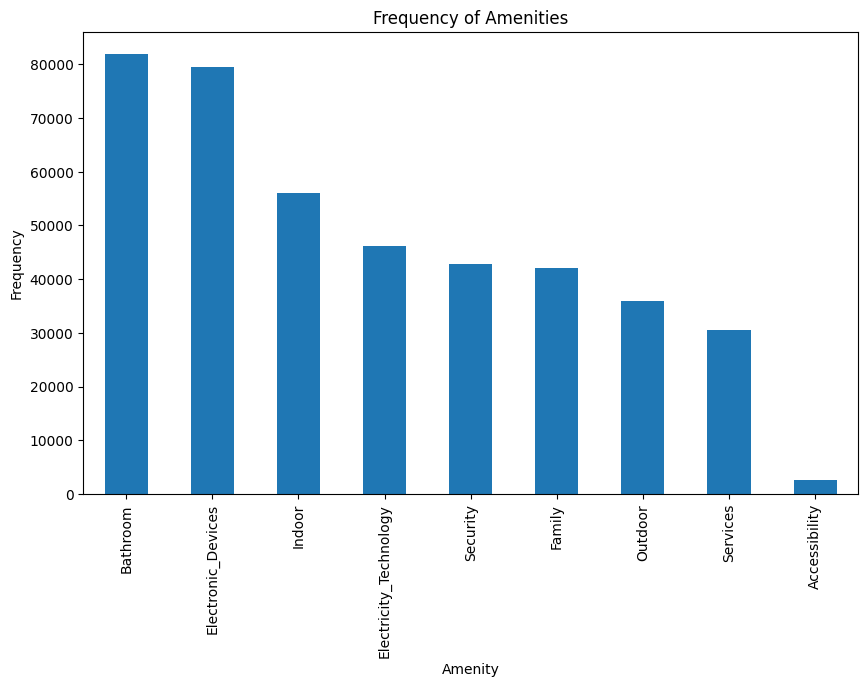

In [23]:
# ####################################################################### #
# Question 1.11

# Read the data from the CSV file
df = pd.read_csv('output.csv')

# Split the words in each row of the 'amenities' column
df['amenities'] = df['amenities'].str.split()

# Count the frequency of each word
word_counts = df['amenities'].explode().value_counts()

# List of words to plot
words_to_plot = ['Electricity_Technology', 'Indoor', 'Electronic_Devices', 'Security', 'Services', 'Bathroom', 'Family', 'Accessibility', 'Kitchen', 'Outdoor']

# Filter word_counts to only include the words in words_to_plot
filtered_word_counts = word_counts[word_counts.index.isin(words_to_plot)]

# Plot the word counts
plt.figure(figsize=(10, 6))
filtered_word_counts.plot(kind='bar')
plt.title('Frequency of Amenities')
plt.xlabel('Amenity')
plt.ylabel('Frequency')

# Save the plot to a file
plt.savefig('question_1_11.png')

# ####################################################################### #

Ερώτημα 1.12

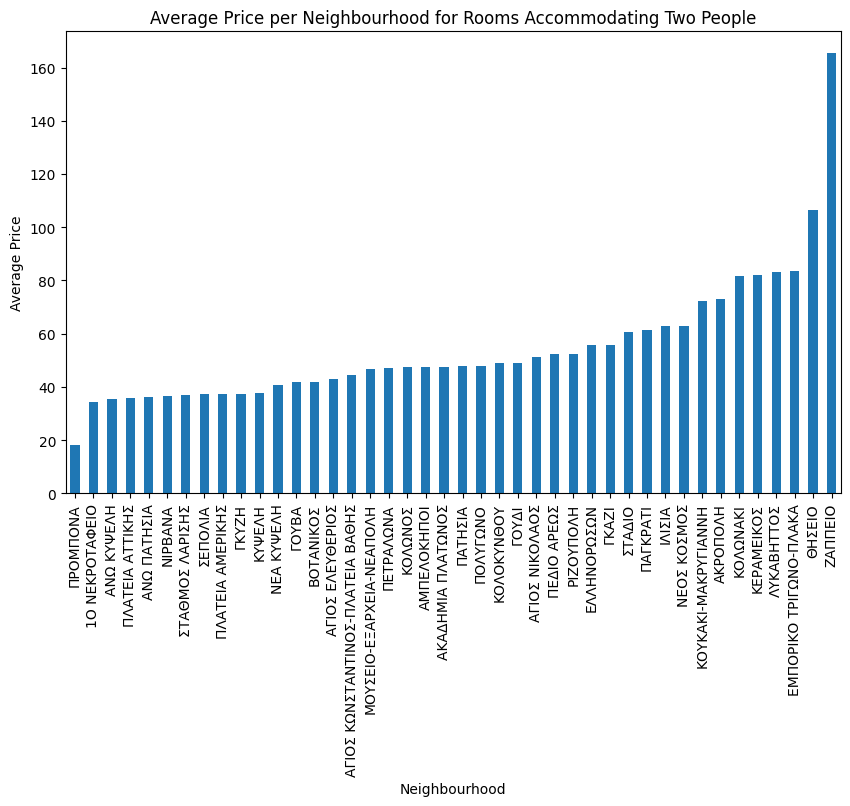

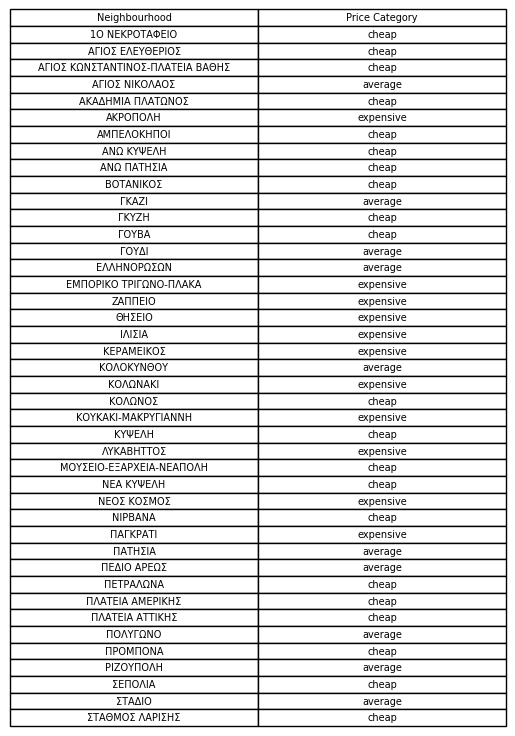

In [24]:
# ####################################################################### #
# Question 1.12

# Read the data from the CSV file
df = pd.read_csv('output.csv')

# Remove the dollar sign and commas from the price column and convert it to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Filter the DataFrame to only include listings that accommodate two people
df_two_people = df[df['accommodates'] == 2]

# Group by neighbourhood and calculate the mean price
mean_price_per_neighbourhood = df_two_people.groupby('neighbourhood_cleansed')['price'].mean()

# Sort by mean price
sorted_neighbourhoods = mean_price_per_neighbourhood.sort_values()

# Plot the results
plt.figure(figsize=(10, 6))
sorted_neighbourhoods.plot(kind='bar')
plt.title('Average Price per Neighbourhood for Rooms Accommodating Two People')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price')

# Save the plot to a file
plt.savefig('question_1_12_plot.png')

# Define the bin edges based on the min, median and max values
bins = [np.min(mean_price_per_neighbourhood),
        np.percentile(mean_price_per_neighbourhood, 50),
        np.percentile(mean_price_per_neighbourhood, 75),
        np.max(mean_price_per_neighbourhood)]

# Define the labels for the bins
labels = ['cheap', 'average', 'expensive']

# Create a new column 'price_category' by cutting the mean price into bins
mean_price_per_neighbourhood = pd.cut(mean_price_per_neighbourhood, bins=bins, labels=labels, include_lowest=True)

# Get data
neighbourhoods = mean_price_per_neighbourhood.index.tolist()
price_categories = mean_price_per_neighbourhood.tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(neighbourhoods, price_categories))
ax.table(cellText=table_data, colLabels=['Neighbourhood', 'Price Category'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_12_table.png')

# ####################################################################### #

Ερώτημα 1.13

(α) Ποια γειτονια εχει τους περισσοτερους host identity verified.

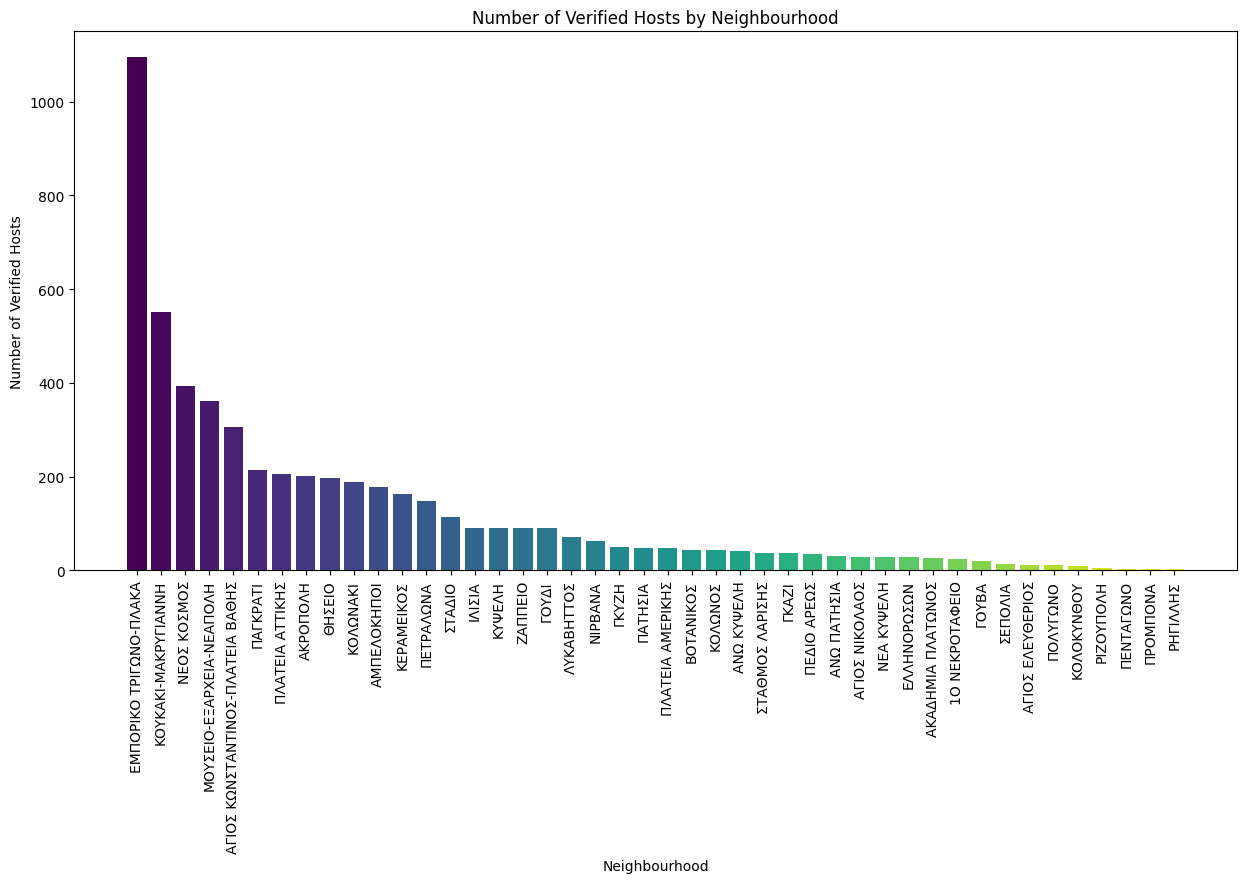

In [25]:
# ####################################################################### #
# Question 1.13

# (a) ___________________________________________________________________ #
# ποια γειτονια εχει τους περισσοτερους host identity verified

# Read the data from the CSV file
df = pd.read_csv('output.csv')

# Filter rows where 'host_identity_verified' is True
df = df[df['host_identity_verified'] == 't']

# Group by 'neighbourhood' and count the number of unique 'id's
neighbourhood_counts = df.groupby('neighbourhood_cleansed')['id'].nunique()

# Sort the counts in descending order
sorted_neighbourhoods = neighbourhood_counts.sort_values(ascending=False)

# Get data
neighbourhoods = sorted_neighbourhoods.index.tolist()
number_of_verified_hosts = sorted_neighbourhoods.tolist()

# Create figure with larger size
fig, ax = plt.subplots(figsize=(15, 7))  # Adjust the size as needed

# Create a color array
colors = plt.cm.viridis(np.linspace(0, 1, len(neighbourhoods)))

# Create bar chart with colors
ax.bar(neighbourhoods, number_of_verified_hosts, color=colors)

# Set the title and labels
ax.set_title('Number of Verified Hosts by Neighbourhood')
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Number of Verified Hosts')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Save the plot to a file
plt.savefig('question_1_13_a.png')

# ####################################################################### #

Ερώτημα 1.13

(β) Μέσος όρος βαθμολογιών ανά περιοχή, κάθε μήνα.

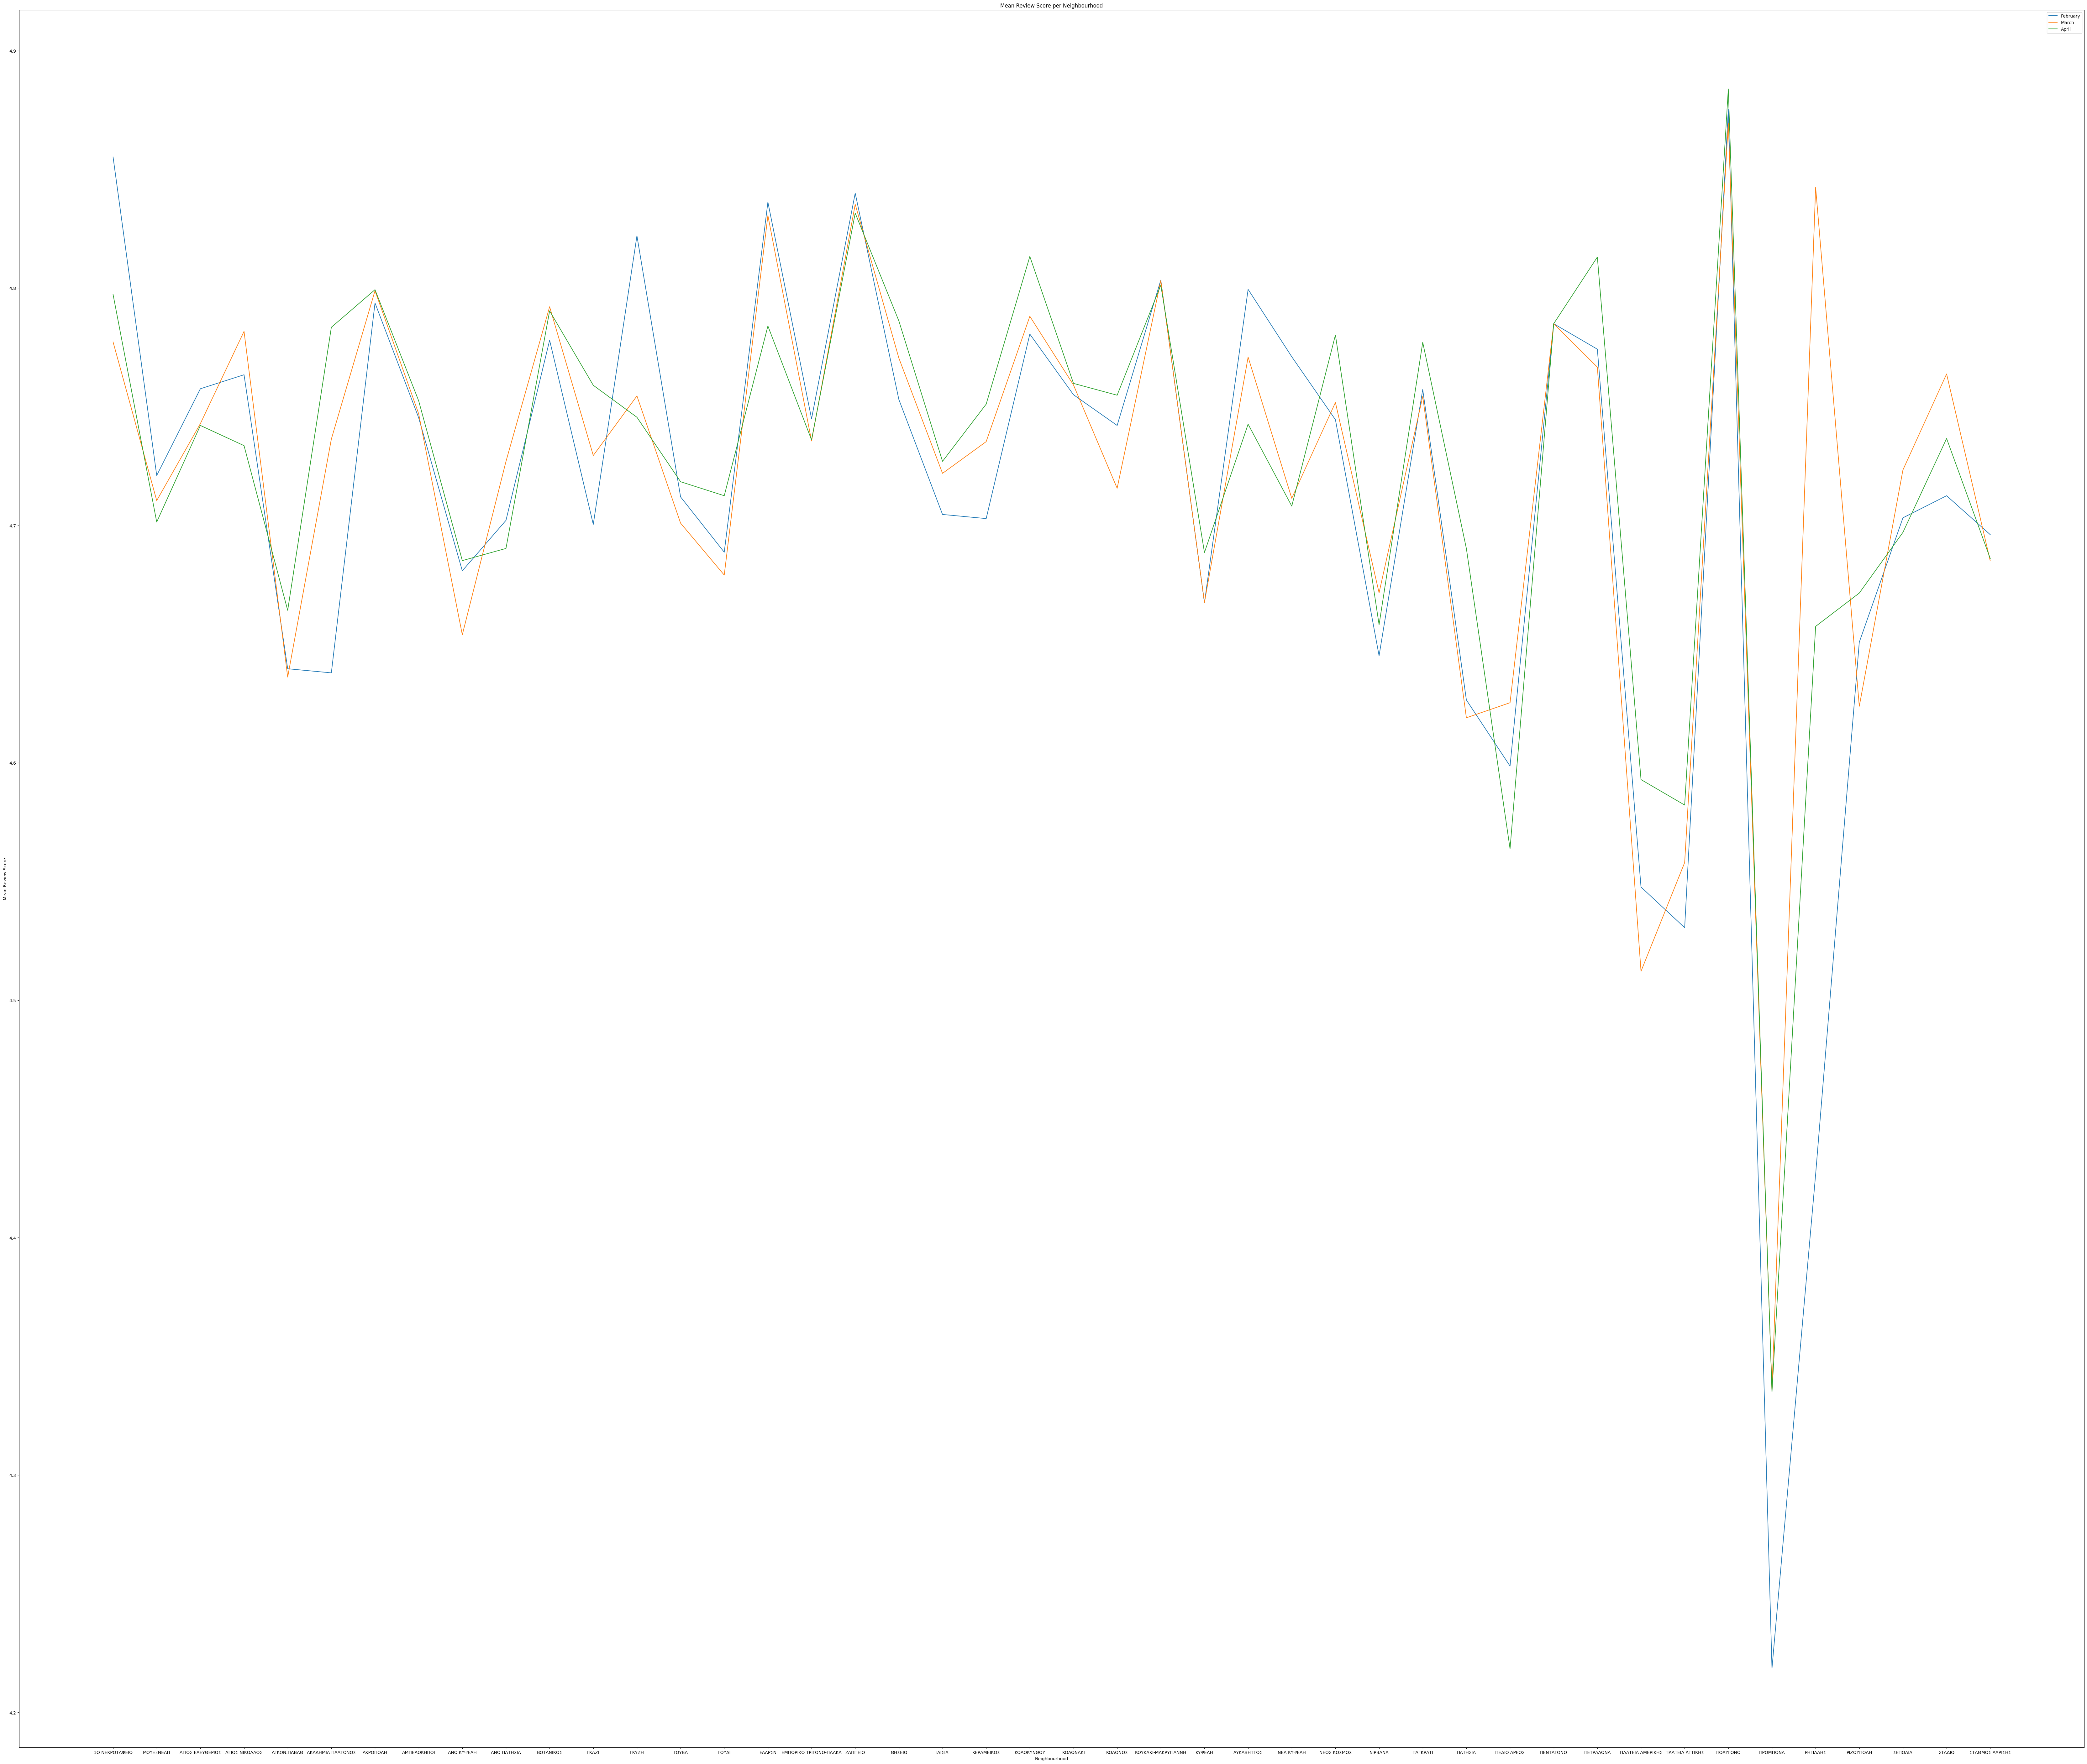

In [26]:
# ####################################################################### #
# Question 1.13

# (b) ___________________________________________________________________ #

# Load the data
df_ju = pd.read_csv(listings_path_june)
df_mar = pd.read_csv(listings_path_march)
df_sep = pd.read_csv(listings_path_september)

df_ju = df_ju.replace('ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ', 'ΑΓΚΩΝ.ΠΛΒΑΘ')
df_mar = df_mar.replace('ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ', 'ΑΓΚΩΝ.ΠΛΒΑΘ')
df_sep = df_sep.replace('ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ', 'ΑΓΚΩΝ.ΠΛΒΑΘ')

df_ju = df_ju.replace('ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ', 'MOΥΕΞΝΕΑΠ')
df_mar = df_mar.replace('ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ', 'MOΥΕΞΝΕΑΠ')
df_sep = df_sep.replace('ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ', 'MOΥΕΞΝΕΑΠ')

df_ju = df_ju.replace('ΕΛΛΗΝΟΡΩΣΩΝ', 'ΕΛΛΡΣΝ')
df_mar = df_mar.replace('ΕΛΛΗΝΟΡΩΣΩΝ', 'ΕΛΛΡΣΝ')
df_sep = df_sep.replace('ΕΛΛΗΝΟΡΩΣΩΝ', 'ΕΛΛΡΣΝ')



# Calculate mean review score per neighbourhood for each month
mean_scores_ju = df_ju.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()
mean_scores_mar = df_mar.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()
mean_scores_sep = df_sep.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()

# Plot the results
plt.figure(figsize=(85, 72))  # Increase the x-dimension of the figure size
plt.plot(mean_scores_mar, label='February')
plt.plot(mean_scores_ju, label='March')
plt.plot(mean_scores_sep, label='April')
plt.title('Mean Review Score per Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean Review Score')
plt.legend()
plt.show()
# ####################################################################### #

Ερώτημα 1.13

(γ) Μέσος όρος τιμής ανά είδος κατοικίας.

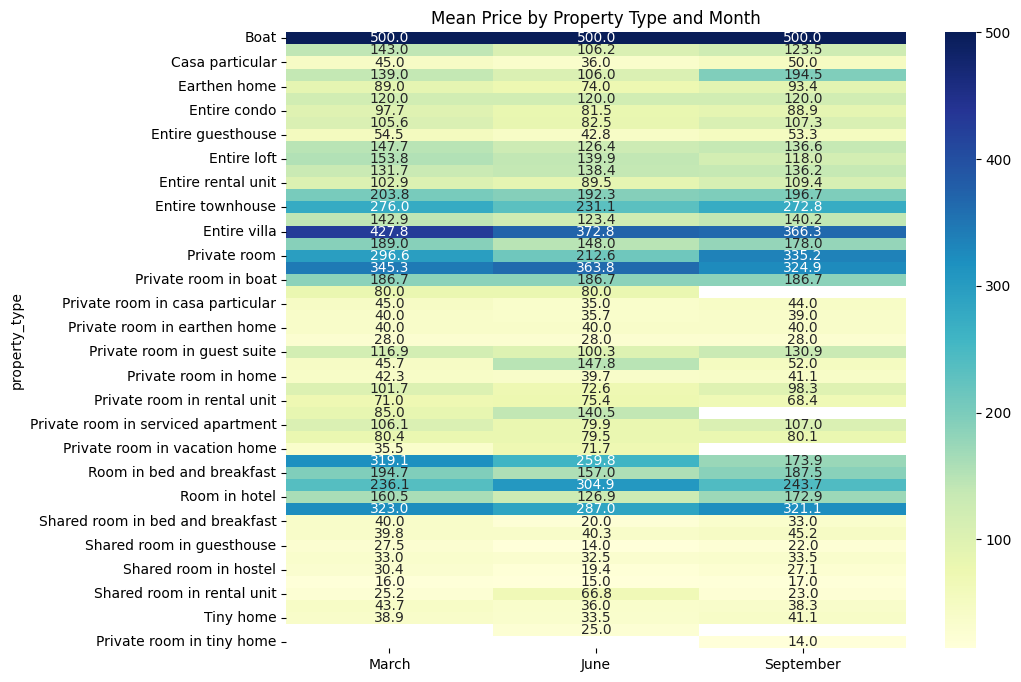

In [27]:
# ####################################################################### #
# Question 1.13

# (c) ___________________________________________________________________ #

# Define a function to clean the price column
def clean_price(price):
    if isinstance(price, str):
        price = price.replace('$', '')
        price = price.replace(',', '')  # Add this line to remove commas
        price = float(price)
    return round(price, 1)

# Apply the function to the price column of each DataFrame
df_ju['price'] = df_ju['price'].apply(clean_price)
df_mar['price'] = df_mar['price'].apply(clean_price)
df_sep['price'] = df_sep['price'].apply(clean_price)

# Group each DataFrame by property type and calculate the mean price
mean_price_ju = df_ju.groupby('property_type')['price'].mean()
mean_price_mar = df_mar.groupby('property_type')['price'].mean()
mean_price_sep = df_sep.groupby('property_type')['price'].mean()

# Merge the resulting DataFrames on the property type column
df = pd.concat([mean_price_ju, mean_price_mar, mean_price_sep], axis=1)
df.columns = ['March', 'June', 'September']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Mean Price by Property Type and Month')
plt.show()


Ερώτημα 1.14

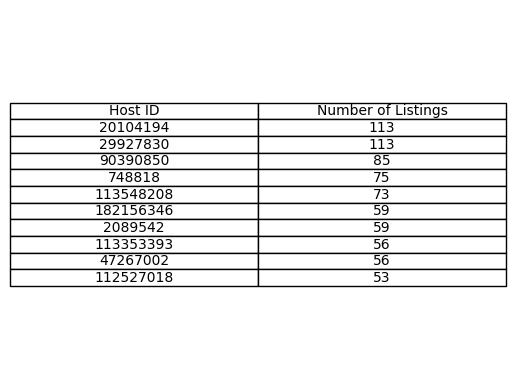

In [28]:
# ####################################################################### #
# Question 1.14

# Group by 'host_id' and count the number of unique 'id's
host_counts = listings0_df.groupby('host_id')['id'].nunique()

# Sort the counts in descending order
sorted_hosts = host_counts.sort_values(ascending=False)

# Select the first 10 hosts
top_hosts = sorted_hosts.head(10)

# Get data
host_ids = top_hosts.index.tolist()
number_of_listings = top_hosts.tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(host_ids, number_of_listings))
ax.table(cellText=table_data, colLabels=['Host ID', 'Number of Listings'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_14.png')

# ####################################################################### #

Ερώτημα 1.15

Παρατηρούμε τις εξής διαφορές/ομοιόιτητες μεταξύ των δύο ετών.

*  Όσον αφορά την πορεία των τιμών μεταξύ των δύο ετών, πρόκυπτει ότι την χρονιά 2023 ο μέσος όρος των τιμών είχε ανοδική πορεία και σε ορισμένες περιπτώσεις σχεδόν διπλασιάστηκε σε σχέση με το 2019. Επίσης η πορεία των τιμών μεταξύ των μηνών Φεβρουάριος, Μάρτιος, Απρίλιος το 2019 είναι σχεδόν σταθερή, ενώ η πορεία των τιμών μεταξύ των μηνών Μάρτιος, Ιούνιος, Σεπτέμβριος το 2023 είναι ανοδική τους πρώτους δύο απο αυτούς τους μήνες και στη συνέχεια φαίνεται να σταθεροποιείται ο μέσος όρος των τιμών τον τελευταίο μήνα.

* Όσον αφορά των αριθμό των καταχωρήσεων μεταξύ των δύο ετών, παρατηρούμε ότι και τις δύο χρονιές οι πρώτες δέκα σε αριθμό καταχωρήσεων περιοχές παραμένουν ίδιες , ωστόσο την χρονιά 2023 οι καταχωρήσεις είναι περισσότερες σε κάθε μία απο αυτές.

* Μεταξύ των δύο ετών υπάρχουν διαφοροποιήσεις στο μέσο όρο των τιμών για κάθε είδος δωματίου. Συγκεκριμένα το 2019 ο πιο ακριβός τύπος δωματίου ήταν το Entire home/apt, ακολουθούμενο απο το Private room και απο το Shared room. Aπο την άλλη ο πιο ακριβός τύπος δωματίου το 2023 ήταν το Hotel room, έπειτα ακολουθούσαν το Private room, Entire home/apt και Shared room. Ορισμένες διαφορές μεταξύ των πιο ακριβών δωματίων το Entire home/apt αυξήθηκε κατά 40€ το 2023 σε σχέση με το 2019, ομοίως το Private room αυξήθηκε κατά 90€ το 2023 σε σχέση με το 2019 και ξεπέρασε το Entire home/apt σε μέσο όρο τιμής, όπως επίσης και το Shared room αυξήθηκε κατά 20€ το 2023 σε σχέση με το 2019. Επιπλέον το 2023 εμφανίστηκε ένας νέος τύπος δωματίου το Hotel room, το οποίο έτεινε να αγγίζει τα 200€.
  
* Μεταξύ των δύο ετών προκύπτουν διαφορές όσον αφορά ορισμένες γειτονιές, καθώς άλλαξε η αγοραστική τους αξία και αυτό φαίνεται στον παρακάτω πίνακα. Συγκερκιμένα οι παρακάτω περιοχές χαρακτηρίστηκαν ως ακριβότερες ή φθηνότερες. Επίσης το 2023 δεν υπήρχε καταχώρηση στην περιοχή ΠΕΝΤΑΓΩΝΟ, ενώ υπήρχε η περιοχή ΠΡΟΜΠΟΝΑΣ η οποία την χρονιά 2019 δεν είχε κάποια καταχώρηση. Οι υπόλοιπες περιοχές παρέμειναν ίδιες όσον αφορά την αξία τους. Αξίζει να σημειωθεί ότι η περιοχή του Ζαππείου ο μέσος όρος τιμής απο 45€ αυξήθηκε στα 200€, ενώ γενικά υπήρχε μια ανοδική πορεία με κάποιες τιμές να έχουν διπλασιαστεί.

\begin{array}{|c|c|} \hline
   & 2019 & \rightarrow & 2023 \\ \hline
  1ο\ ΝΕΚΡΟΤΑΦΕΙΟ & expensive & \rightarrow & average \\ \hline
  ΑΓΙΟΣ\ ΕΛΕΥΘΕΡΙΟΣ & cheap & \rightarrow & expensive \\\hline
  ΑΓΙΟΣ\ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ\ ΒΑΘΗΣ & cheap & \rightarrow & average \\ \hline
  ΑΚΑΔΗΜΙΑ\ ΠΛΑΤΩΝΟΣ & expensive & \rightarrow & cheap \\ \hline
  ΒΟΤΑΝΙΚΟΣ & average & \rightarrow & cheap \\ \hline
  ΓΟΥΔΙ & average & \rightarrow &cheap \\ \hline
  ΕΛΛΗΝΟΡΩΣΩΝ & cheap & \rightarrow & expensive \\ \hline
  ΚΟΛΩΝΟΣ & average & \rightarrow & cheap \\ \hline
  ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ & average & \rightarrow & expensive \\ \hline
  ΝΕΟΣ\ ΚΟΣΜΟΣ & expensive & \rightarrow & average \\ \hline
  ΠΑΓΚΡΑΤΙ & average & \rightarrow & expensive \\ \hline
  ΡΗΓΙΛΛΗΣ & cheap & \rightarrow & average \\ \hline
  ΣΤΑΔΙΟ & expensive & \rightarrow & average \\ \hline
\end{array}

# Ερώτημα 2ο: Recommendation System


In [31]:
def get_top_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def recommend(item_id, num):
    # Load the similar IDs dictionary from the JSON file
    with open('similar_ids_dict.json', 'r') as f:
        similar_ids_dict = json.load(f)

    # Load the similar scores dictionary from the JSON file
    with open('similar_scores_dict.json', 'r') as f:
        similar_scores_dict = json.load(f)

    # Convert the item_id to str (since the keys in the dictionary are strings)
    item_id = str(item_id)

     # Check if the item_id exists in the dictionaries
    if item_id not in similar_ids_dict or item_id not in similar_scores_dict:
        return f"Item ID {item_id} not found in the dictionaries."

    # Get the list of similar IDs and scores for the given item_id
    similar_ids = similar_ids_dict[item_id]
    similar_scores = similar_scores_dict[item_id]

    # Check if the number of similar IDs is less than the requested number
    if len(similar_ids) < num:
        return f"Only {len(similar_ids)} similar items found for item ID {item_id}."

    # Get the top num similar IDs and scores
    top_similar_ids = similar_ids[:num]
    top_similar_scores = similar_scores[:num]

    # Print the recommended items
    print(f"Recommending {num} listings similar to item ID {item_id}")
    print("---------------------------------------------------------")
    for id, score in zip(top_similar_ids, top_similar_scores):
        # Assuming df is the DataFrame that contains the item details
        item = df[df['id'] == int(id)]
        print(f"Recommended: {item['name'].values[0]}")
        print(f"Description: {item['description'].values[0]}")
        print(f"Score: {score}")
        print("......")

In [40]:
new_df = df.copy()
new_df['description_name'] = df['description'] + " " + df['name']
new_df['description_name'] = new_df['description_name'].str.replace(' etc', '')

new_df = new_df.dropna()

new_df.to_csv('new_df.csv', index=False)

# Keep only the first 7000 lines
# df = df.iloc[:4000]

# Step 1: Read the CSV file into a DataFrame
new_df = pd.read_csv('new_df.csv')

# text cleaning
new_df = text_cleaning(new_df)

# Step 2: Extract the 'description_name' column and convert it into a TF-IDF matrix
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(new_df['description_name'])

# Step 3: Calculate the cosine similarity matrix for the TF-IDF matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Step 4: For each row in the cosine similarity matrix, find the indices of the top 300 most similar items
top_300_similar_indices = np.argsort(cosine_sim_matrix, axis=1)[:, -301:-1]  # We use -301:-1 to exclude the self index

# Step 5: Create a dictionary where the keys are the IDs and the values are lists of the 100 most similar IDs
similar_ids_dict = {new_df.iloc[i]['id']: list(set([id for id in new_df.iloc[top_300_similar_indices[i]]['id'] if id != new_df.iloc[i]['id']]))[:100] for i in range(new_df.shape[0])}

# Create a dictionary where the keys are the IDs and the values are lists of the 100 most similar scores
similar_scores_dict = {new_df.iloc[i]['id']: list(set([cosine_sim_matrix[i][j] for j in top_300_similar_indices[i] if new_df.iloc[j]['id'] != new_df.iloc[i]['id']]))[:100] for i in range(new_df.shape[0])}
similar_scores_dict = {str(k): v for k, v in similar_scores_dict.items()}


# Convert the keys to str
similar_ids_dict = {str(k): v for k, v in similar_ids_dict.items()}

# Now write the dictionary to a JSON file
with open('similar_ids_dict.json', 'w') as f:
    json.dump(similar_ids_dict, f)

with open('similar_scores_dict.json', 'w') as f:
    json.dump(similar_scores_dict, f)

In [39]:
# Assuming similarity_matrix is defined
recommend(10595, 5)

# Read the CSV file
new_df = pd.read_csv('new_df.csv')

# Extract the 'description_name' column
corpus = new_df['description_name'].tolist()

# Tokenize the text
tokens = [word_tokenize(text) for text in corpus]

# Flatten the list of tokens
tokens = [token for sublist in tokens for token in sublist]

# Filter out tokens that are numbers
tokens = [token for token in tokens if not re.match(r'^\d+$', token)]

# Find bigrams
bigram_finder = BigramCollocationFinder.from_words(tokens)

# Get the 10 most common bigrams
bigrams = bigram_finder.nbest(BigramAssocMeasures.raw_freq, 10)

for bigram in bigrams:
    print(bigram)

Recommending 5 listings similar to item ID 10595
---------------------------------------------------------
Recommended: Rental unit Athina 4 92 2 bedroom 4 bed 1 bath
Description: LIVE IN STYLE IN OUR BRAND NEW LUXURIUS APARTMENT AT THE CENTER OF ATHENS The apartment located keramikos heart Athens nly 5 10 minute walk Acropolis Psirri Gkazi Monastiraki It 5 minute walk subway metro station Omonoia Metaxourgeio fastest transport city In 2 5 minute walk apartment find plenty restaurant bar mini market bank shop Everything need step away The space AP 3 luxurius 90m 3rd floor apartment accommodate 6 adult The apartment feature specious living room double sofa bed accommodate 2 extra quest fully equipped kitchen double bed bedroom 2 single bed bedroom one bathroom One bed available upon request case needed The living room equipped satellite TV The apartment kitchen fully equipped
Score: 0.04563638763914013
......
Recommended: Rental unit Athina 4 98 1 bedroom 2 bed 1 bath
Description: Styli